<img src="../../img/continuous_changepoint_detection.png" alt="change point detection" style="width: 100%; border-radius: 20px;"/>

<br><br>

> **Disclaimer**:
**The approaches in this notebook demonstrated limitations. Moving forward, alternative methods will be explored.**
The continuous change point detection approach showed limitations in effectively differentiating between seasonally induced drifts and "real" drifts in bird populations. Additionally, the rolling window smoothing approach will be changed to a more accurate decade-based approach (see notebook `06_time_series_decade_smoothing.ipynb`).

## Objective
The objective of this notebook is to analyze and preprocess the raw time series data of bird sightings and apply change point detection algorithms to continuously identify gradual and sudden drifts in the distribution of the data. The focus is on detecting habitat and date drifts in specific geographic grids. The notebook aims to discuss the strengths and limitations of the applied algorithms and preprocessing methods, as well as propose possible directions for future analysis.

## Scope
The scope of this notebook includes:

- Preprocessing of the raw time series data through rolling window smoothing to reduce noise and fluctuations.
- Application of a change point detection algorithm, specifically KSWIN, to identify shifts in the sighting distribution of the bird sighting data.
- Analysis of the effectiveness of the algorithms in detecting habitat and date drifts, with a focus on the pygmy owl and icterine warbler.
- Discussion of the strengths and limitations of the continuous change point detection approach, as well as the rolling window smoothing method.
- Proposal of possible directions for future analysis, including the need to address seasonal characteristics of the sighting data and adapt the applied smoothing approach.

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 📦 Install River package </p>

In this notebook, [riverml](https://riverml.xyz/dev/) will be applied for a KSWIN implementation. 

Usually, you can easily install it via `pip install river`.

However, with Mac, they are currently facing issues with this. If you get an error looking something like `ERROR: Could not build wheels for river, which is required to install pyproject.toml-based projects`, run the following commandline:

In [ ]:
!pip install git+https://github.com/online-ml/river --upgrade

In [17]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import pandas as pd
from river import drift

from utils.plotting import *
from utils.drift import *

import warnings
warnings.filterwarnings('ignore')

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following file is required:
- Time series of bird sightings: *[time_series_27_species.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*

In [3]:
path_sightings = '../../../01_Data/datasets/time_series_27_species.csv'

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ The raw data </p>

Below are two exemplary time series depicting the sighting frequencies for the pygmy owl and the icterine warbler over the entire observation period from 2018 to 2022 in a 50x50km grid around Basel (CH) and Hannover (DE), respectively. These specific bird species and grids were chosen for the change point analysis due to the pygmy owl exhibiting a distribution drift in the selected grid, while the icterine warbler shows a date drift. The characteristics of the drift will be detailed in chapter 3️⃣.

> Further details about the drifts can be found in the notebooks `02_habitat_drift.ipynb` and `03_date_drift.ipynb`.

In [4]:
df = pd.read_csv(path_sightings)

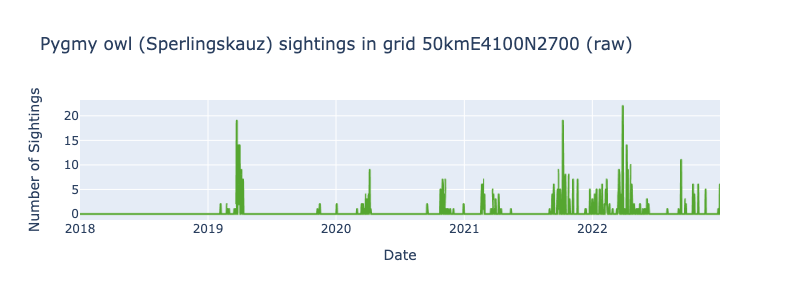

In [5]:
pygmy_owl = df[(df.name_species == 'Sperlingskauz') & (df.eea_grid_id == '50kmE4100N2700')].reset_index(drop=True)
plot_time_series(data=pygmy_owl, title='Pygmy owl (Sperlingskauz) sightings in grid 50kmE4100N2700 (raw)')

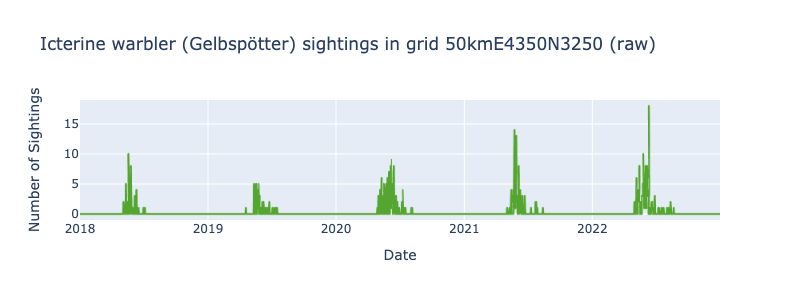

In [6]:
warbler = df[(df.name_species == 'Gelbspötter') & (df.eea_grid_id == '50kmE4350N3250')].reset_index(drop=True)
plot_time_series(data=warbler, title='Icterine warbler (Gelbspötter) sightings in grid 50kmE4350N3250 (raw)')

#
<p style="background-color:#4A3228;color:white;border-radius:10px 10px 10px 10px; padding: 10px;"> &nbsp; 
<span style="font-size:240%;">2️⃣ Preprocessing</span><br>
<span style="font-size:120%;font-style:italic;padding-left:50px;">Smoothing with rolling window averaging</span>
</p>

As can be seen above, the time series are highly noisy and exhibit rapid fluctuations. Therefore, as a preprocessing step, the curves are smoothed to make them more amendable for change point analysis.

Smoothing a volatile, unsmoothed time series as a preprocessing step for change point analysis offers several advantages. Firstly, it mitigates the noise and variability inherent in the raw data, thereby enhancing the identification of meaningful patterns and trends. Consequently, this contributes to a more precise detection of change points, as the smoothed data offers a clearer depiction of the underlying sighting patterns.

To achieve this, our first approach will be to apply a 30-day rolling window to calculate the mean of the time series data, effectively smoothing out short-term fluctuations and variability in the dataset. The smoothed curves are visualized below and can be compared to the raw time series above.

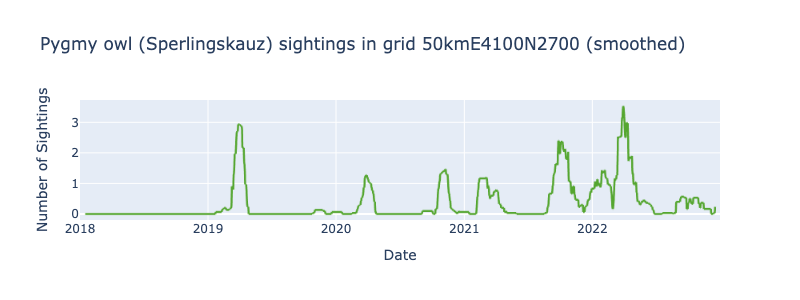

In [7]:
smoothed_pygmy_owl = pygmy_owl.copy()
smoothed_pygmy_owl['n_sightings'] = pygmy_owl['n_sightings'].rolling(window=30, center=True).mean()
plot_time_series(data=smoothed_pygmy_owl, title='Pygmy owl (Sperlingskauz) sightings in grid 50kmE4100N2700 (smoothed)')

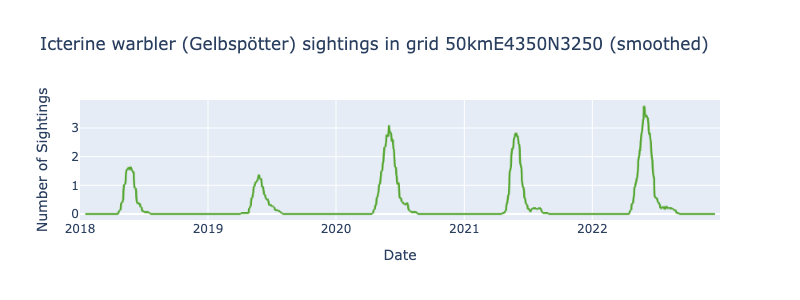

In [8]:
smoothed_warbler = warbler.copy()
smoothed_warbler['n_sightings'] = warbler['n_sightings'].rolling(window=30, center=True).mean()
plot_time_series(data=smoothed_warbler, title='Icterine warbler (Gelbspötter) sightings in grid 50kmE4350N3250 (smoothed)')

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Change point detection </p>

Change point detection is a statistical method used to identify shifts in the probability distribution of a stochastic process or time series. This can help in identifying concept drift by signaling when the data distribution changes significantly, allowing for informed decision-making and model updates. 

There are multiple algorithms for change point detection. Unlike the reports by EvidentlyAI in the previous notebooks, these change point detection methods continuously monitor the data for changes, meaning they detect changes continuously rather than comparing data distributions on a yearly or periodic basis. The most common algorithms, such as ADWIN, KSWIN, and Page Hinkley Test have slight differences in their calculations and assumptions: 

**`1️⃣ ADWIN (ADaptive WINdowing):`** This algorithm maintains a variable-size sliding window of data points and continuously monitors statistical properties. When a change is detected, the window size is adjusted to adapt to the new data distribution. The key idea is to maintain a window of variable size, where the window grows when no change is detected and shrinks when a change is detected. This allows to handle both gradual and sudden changes. 

**`2️⃣ KSWIN (Kolmogorov-Smirnov WINdowing):`** Unlike ADWIN, KSWIN uses kernel density estimation within a sliding window to detect changes in the data's underlying distribution.

**`3️⃣ Page Hinkley Test:`** This sequential analysis technique detects changes in the average of a Gaussian process by considering the magnitude of the change.

As an initial algorithm, KSWIN will be applied; if the sliding-window-approach looks promising, further algorithms can be adopted and compared to KSWIN.

### The pygmy owl: Detecting habitat drifts
Below is the time series of sightings of the pygmy owl, with sighting frequency on the y-axis. Upon examining the curves, it is noticeable that the pygmy owl was never sighted in the specified grid around Basel (CH) until 2019. Therefore, according to our understanding, a concept drift (or anomaly) would occur in early 2019, as the sighting of a pygmy owl in this grid was previously very unlikely; with multiple sightings in the spring of 2019, reviewers would consider the submission of a sighting as more likely and may approve it, hence there is a concept drift as the label of the input variable *Sighting of a pygmy owl* shifts from *implausible* to *rather plausible*. Since the sightings subsequently decrease, this increase could arguably also be considered an anomaly; however, this notebook is initially focused on identifying change points. A distinction will be made in subsequent notebooks. Another concept drift could be that the sightings generally gradually increase over the years and in the winter of 2021, where the sightings do not decrease to zero as in previous years.

As we can see, KSWIN recognizes some change points, including the change that in the fall of 2021, the sightings do not decrease as in previous years. Many change points are, according to their definition, set at sudden increases and decreases. The accuracy and timeliness of the set change points appear reasonably accurate. The change that the sightings do not decrease in the fall of 2021 and the bird was observed throughout the winter is also marked.

However, we see that many increases and decreases can be attributed to the seasonality of bird sightings. As Simon showed in his EDA notebook, user activity on the portals ornitho.de and ornitho.ch decreases significantly in the colder months. Therefore, sightings of resident birds such as the pygmy owl also decrease, even though the bird still resides in Germany and Switzerland. Hence, an increase in the spring and decrease in the fall is a normal seasonally based characteristic of our time series, and not an indication of an anomaly or drift (with the exception if these change points shift over the years; for example, an increased sighting of the bird in the winter of 2021). Since a change point is simply defined as an increase or decrease in the data, our algorithms cannot differentiate between seasonally induced and "real" drifts and anomalies by definition. Further considerations and possible future directions on this matter can be found in Chapter 3️⃣.

The situation becomes even clearer when considering the icterine warbler, a migratory bird with high seasonality (see next chapter).

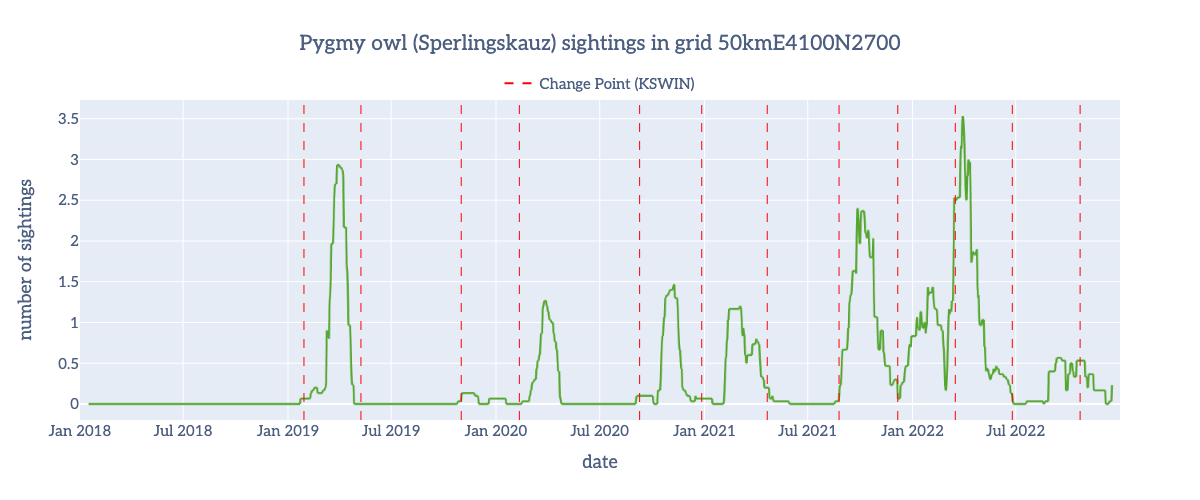

In [15]:
stream = smoothed_pygmy_owl['n_sightings'].values
change_detector = drift.KSWIN(window_size=100, stat_size=7)

change_points = []
for i, val in enumerate(stream):
    change_detector.update(val)
    if change_detector.drift_detected:
        change_points.append(i)

plot_change_points(data=smoothed_pygmy_owl, 
                   change_points=change_points,
                   title='Pygmy owl (Sperlingskauz) sightings in grid 50kmE4100N2700')

### The icterine warbler: Detecting date drifts
With the icterine warbler, we can see the clear influence of the seasonality of the data on the algorithms. All change points are, by their definition, set correctly and with little latency, which underscores the ability of the algorithms to detect change points in our data.

However, according to our definition, these change points are not a reason for an anomaly or drift, as they simply reflect the normal migration behavior of the bird.

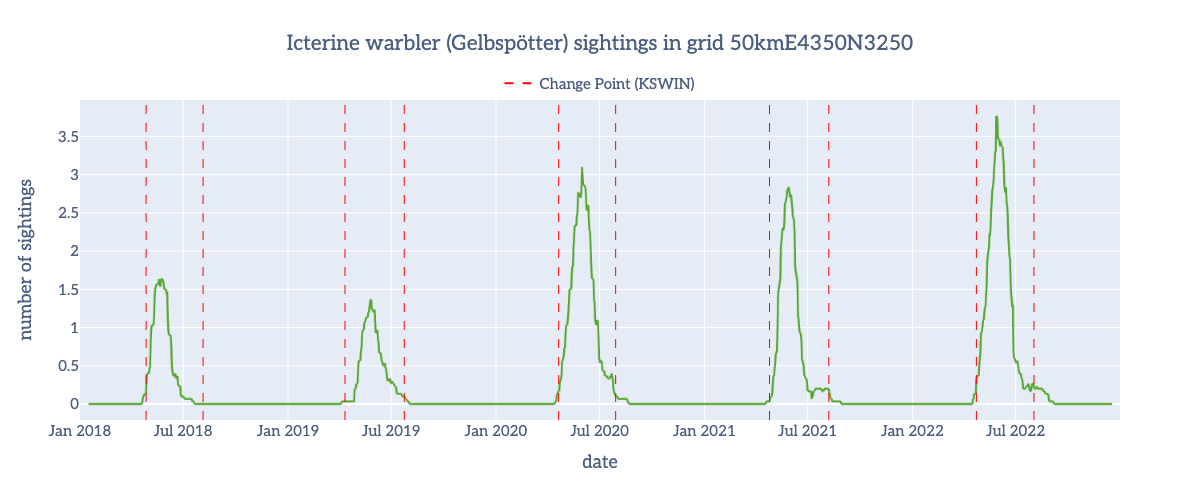

In [18]:
stream = smoothed_warbler['n_sightings'].values
change_detector = drift.KSWIN(window_size=100, stat_size=7)

change_points = []
for i, val in enumerate(stream):
    change_detector.update(val)
    if change_detector.drift_detected:
        change_points.append(i)

plot_change_points(data=smoothed_warbler, 
                   change_points=change_points,
                   title='Icterine warbler (Gelbspötter) sightings in grid 50kmE4350N3250')

In the following figure, the years have been overlaid instead of being represented as a continuous time series.

Here, it is evident how the arrival and departure times of the bird shift over the years. As already shown in `03_date_drift.ipynb`, these shifts are not gradual, but likely randomly fluctuating due to weather conditions. However, in this case, it may not be the occurrence of a change point, but rather *the shifting of recurring change points over the years* that could be defined as drift. Further considerations on this matter can be found in the discussion in Chapter 3️⃣.

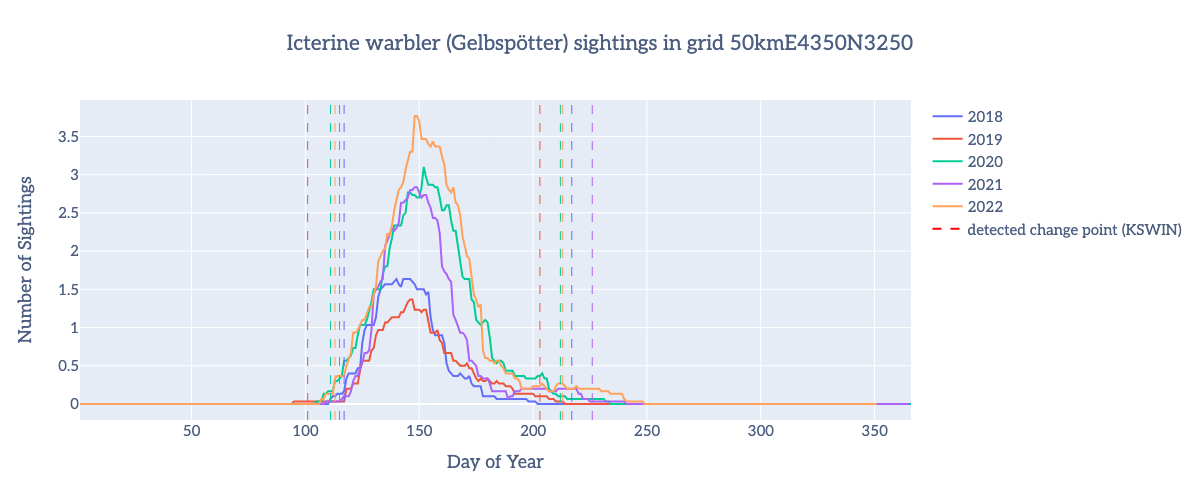

In [13]:
plot_change_points_per_year(data=smoothed_warbler, 
                   change_points=change_points, 
                   title='Icterine warbler (Gelbspötter) sightings in grid 50kmE4350N3250', 
                   legend_title='detected change point (KSWIN)',
                   show_first_sighting=False)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Discussion </p>

## Strenghts of the applied algorithms
The algorithms can effectively detect abrupt as well as gradual changes in the time series with satisfactory accuracy and low latency.

## Limitations of continuous change point detection
As revealed in this notebook, continuous monitoring using sliding windows when applied to bird sighting data presents a challenge. While KSWIN can effectively identify increases or decreases in sightings, the identified changes can mostly be attributed to the seasonality of the sightings, influenced by the migration of a bird or the decrease in user activity in the winter. This seasonality is a normal behavior of bird sightings and does not represent a shift in bird behavior regarding migration, habitat, or population density. However, the algorithms lack this knowledge and the ability to distinguish drifts in bird populations from seasonally induced drifts.

## Limitations of rolling window smoothing
In this notebook, rolling window smoothing was applied to reduce fluctuations, spikes, and irregularities in the time series data. However, after consolidation with @Thomas Clemen, we agreed on shifting to another method as the current approach has limitations when applied to bird sightings data. By using a rolling window, the y-values are based on the number of sightings of that day. This method does not accurately reflect the population density of bird species, as the number of sightings does not equate to the true number of birds present. Rather, the frequency of reports submitted to ornitho can be influenced by user behavior and activeness on different days, leading to incorrect conclusions about bird presence and abundance.


## Possible directions
For the seasonal characteristic of the sighting data, ways need to be found to address the yearly periodic increase and decrease in sightings and to differentiate "real" concept drifts from seasonal events. This requires a definitions of what we understand as a real concept drift. In addition, ways must be devised to algorithmically separate these drifts.

One possibility could be to refrain from continuous monitoring and instead return to comparing the sighting patterns per species and grid over entire yearly periods, similar to the approach in notebooks `02_habitat_drift.ipynb` and `03_date_drift.ipynb`. The advantage here is that seasonality is present in both distributions and thus, if the seasonality remains the same, it is not considered as drift. If a drift in the distribution is detected, the change points could be more accurately determined through statistical analysis to identify the day the drift occurred. With this, in the example of the icterine warbler, the shifting of recurring change points, representing a shift in arrival and departure, could be considered as a gradual drift over the years, rather than considering the bird's arrival as a drift compared to its absence in the winter. Real-time analyses could still be possible. For example, in June of a year, the data from the previous year up to June could be considered, and a drift analysis could be performed within this 6-month period.

To address the limitations of the rolling window smoothing approach, we will adopt a different method commonly used in ornithology. We will analyze the data in decades, where each decade represents a period of 10 days. By measuring on how many days of each decade a bird was sighted at least once, we aim to minimize the influence of user bias and activity on the conclusions drawn about bird presence and abundance. This is expected to provide a more robust and scientifically accurate approach to understand bird species' presence and shifts in specific areas. This will be done in the following notebook `06_time_series_decade_smoothing.ipynb`.